# Neal's Funnel Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
d = 21
@model function funnel()
    θ ~ Truncated(Normal(0, 3), -3, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

@model function true_funnel()
    θ ~ Truncated(Normal(0, 3), -3, 3)
    z ~ MvNormal(zeros(d-1), I)
    zz = z .* exp(θ/2)
    x ~ MvNormal(zz, I)
    
end

true_funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Random.seed!(1)
(;x) = rand(true_funnel() | (θ=0,))
true_model = true_funnel() | (;x)

DynamicPPL.Model{typeof(true_funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(true_funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [0.7273459156073062, -0.7137895625029701, -1.3112158987551843, 3.195064335503728, 0.6578668590997088, 1.8201670957594605, 2.5774094189910475, 1.2959606640141557, -2.615684720848553, -1.7192495259048919, 0.38510954102334116, 0.7049475219687015, 1.4527158089056038, 1.5438517444010695, 0.8504145036053463, 0.9997932200168839, -0.14767140951984356, 0.6046583528834097, -0.38477500804604936, -1.506202996455002],), DynamicPPL.DefaultContext()))

## MCHMC

In [5]:
target = TuringTarget(funnel_model; d=d, compute_MAP=false)
true_target = TuringTarget(true_model; d=d, compute_MAP=false);

In [6]:
spl = MCHMC(10_000, 0.01)
@time samples_mchmc = Sample(spl, target, 100_000; dialog=false);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:02[ Info: eps: 1.695245170169669
[ Info: L: 1.2348771859769547
[ Info: nu: 1.053415444657258
[ Info: sigma: [0.6396474611163719, 0.6991183878502517, 0.6552499259587271, 0.7365178890898229, 0.8579053541646073, 0.7032750559100646, 0.7572780095918319, 0.8338812545297393, 0.7292886335482347, 0.8082774752268378, 0.7150424062335781, 0.6821405755929009, 0.6765705220890924, 0.7110948257739537, 0.7409946902963339, 0.7139858253198895, 0.7169282889479501, 0.71131314333065, 0.7075221927030207, 0.7112116615354115, 0.750632547237526]
[ Info: adaptive: false
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:02

 10.337294 seconds (46.90 M allocations: 21.441 GiB, 14.87% gc time, 57.99% compilation time: 2% of which was recompilation)


In [7]:
spl = MCHMC(10_000, 0.01; adaptive=true)
@time samples_mchmc_adaptive = Sample(spl, target, 100_000; dialog=false);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00[ Info: eps: 1.5162565414360272
[ Info: L: 1.1089148012336874
[ Info: nu: 0.644741717872199
[ Info: sigma: [0.664846587607803, 0.7414128427092886, 0.6726599363394447, 0.6955617120826952, 0.8791910793741272, 0.6827604304955547, 0.7912801465385301, 0.806013174702817, 0.7365275498226725, 0.8326380321821721, 0.7188701196810962, 0.7035380816547483, 0.6948490114565119, 0.7332710597851427, 0.7531448928758456, 0.694516177547652, 0.729293830971487, 0.6720497244183631, 0.6964509202676636, 0.6812382405912177, 0.7343016909156471]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:02

  4.442454 seconds (33.74 M allocations: 20.458 GiB, 21.45% gc time)


In [8]:
#spl_ensemble = MCHMC(0.0, 0.0, 10; init_eps=0.3, varE_wanted=0.1, sigma=ones(d))
#@time samples_mchmc_ensemble = Sample(spl_ensemble, target, 10_000;
#                            burn_in=500, dialog=false);

In [9]:
theta_mchmc = [sample[1] for sample in samples_mchmc]
x10_mchmc = [sample[10+1] for sample in samples_mchmc]
E = [sample[end-1] for sample in samples_mchmc];
VarE = std(E)^2/d

0.01184313241363675

In [10]:
ESSs, rhat = Summarize(samples_mchmc)
ESS = mean(ESSs)
ESS/4.345784

5906.015495711772

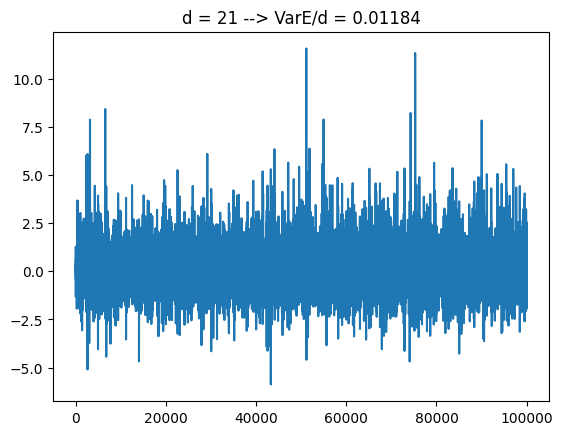

PyObject Text(0.5, 1.0, 'd = 21 --> VarE/d = 0.01184')

In [11]:
plt.plot(E, label="E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE, digits=5)))

In [12]:
theta_mchmc_adaptive = [sample[1] for sample in samples_mchmc_adaptive]
x10_mchmc_adaptive = [sample[10+1] for sample in samples_mchmc_adaptive]
E_adaptive = [sample[end-1] for sample in samples_mchmc_adaptive]
VarE_adaptive = std(E_adaptive)^2/d

0.012375828369405357

In [13]:
ESSs_adaptive, rhat = Summarize(samples_mchmc_adaptive)
ESS_adaptive = mean(ESSs_adaptive)
ESS_adaptive/4.739692

5326.456663199939

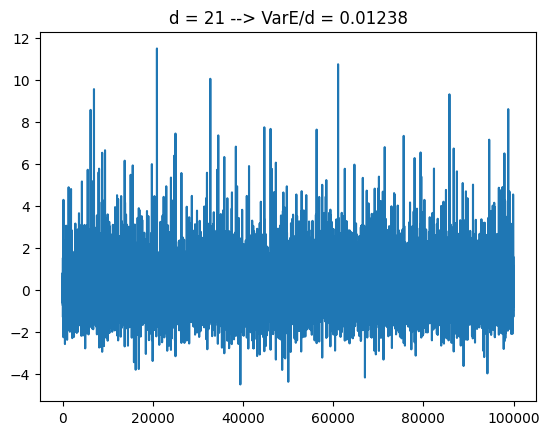

PyObject Text(0.5, 1.0, 'd = 21 --> VarE/d = 0.01238')

In [14]:
plt.plot(E_adaptive, label="E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE_adaptive, digits=5)))

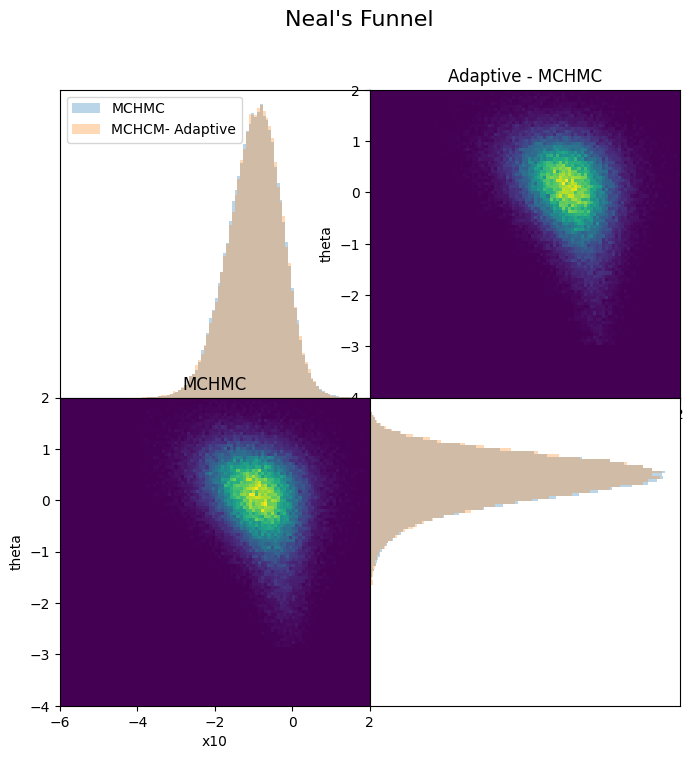

In [18]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, density=true, label="MCHMC")
axis[1,1].hist(x10_mchmc_adaptive, bins=100, range=[-6,2], alpha = 0.3, density=true, label="MCHCM- Adaptive")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].hist(theta_mchmc_adaptive, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(x10_mchmc_adaptive, theta_mchmc_adaptive, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Adaptive - MCHMC")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")
;

## NUTS

In [19]:
samples_hmc = sample(funnel_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.8
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:25


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 28.99 seconds
Compute duration  = 28.99 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

           θ   -0.0094    0.7211     0.0032    0.0081    6774.2145    1.0001   ⋯
        z[1]    0.3652    0.7141     0.0032    0.0028   72442.9419    1.0000   ⋯
        z[2]   -0.3569    0.7199     0.0032    0.0027   71461.3594    1.0000   ⋯
        z[3]   -0.6

In [20]:
truth_hmc = sample(true_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.8
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:11


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 73.27 seconds
Compute duration  = 73.27 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

           θ   -0.0097    0.7246     0.0032    0.0053   17235.9868    1.0001   ⋯
        z[1]    0.3471    0.6980     0.0031    0.0022   81177.9910    1.0000   ⋯
        z[2]   -0.3378    0.7091     0.0032    0.0024   81490.9433    1.0000   ⋯
        z[3]   -0.6

In [21]:
theta_hmc = [samples_hmc.value.data[i, 1, :][1] for i in axes(samples_hmc.value.data)[1]]
x10_hmc = [samples_hmc.value.data[i, 10+1, :][1] for i in axes(samples_hmc.value.data)[1]];


In [22]:
true_theta_hmc = [truth_hmc.value.data[i, 1, :][1] for i in axes(truth_hmc.value.data)[1]]
true_x10_hmc = [truth_hmc.value.data[i, 10+1, :][1] * exp(truth_hmc.value.data[i, 1, :][1]/2) for i in axes(truth_hmc.value.data)[1]];


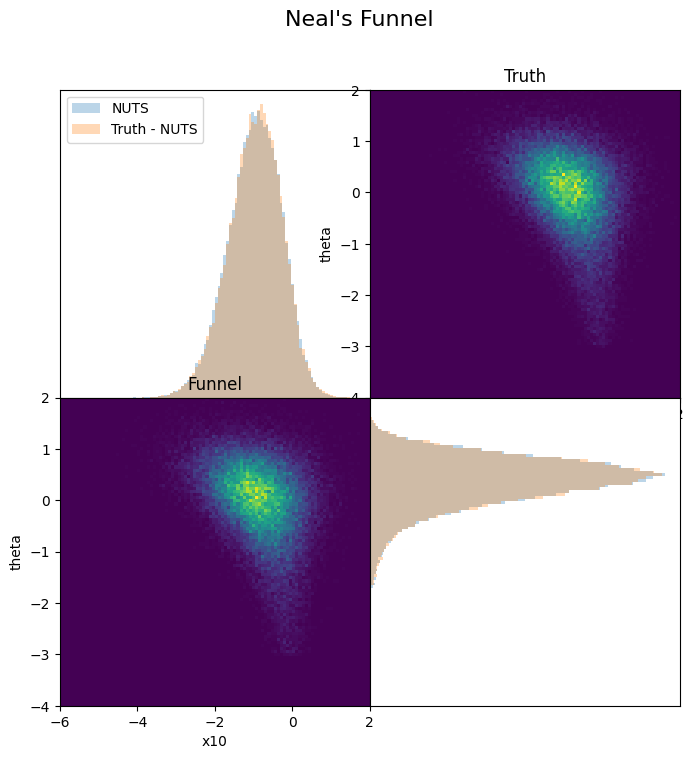

In [23]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="NUTS")
axis[1,1].hist(true_x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="Truth - NUTS")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Truth")

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("Funnel")
;

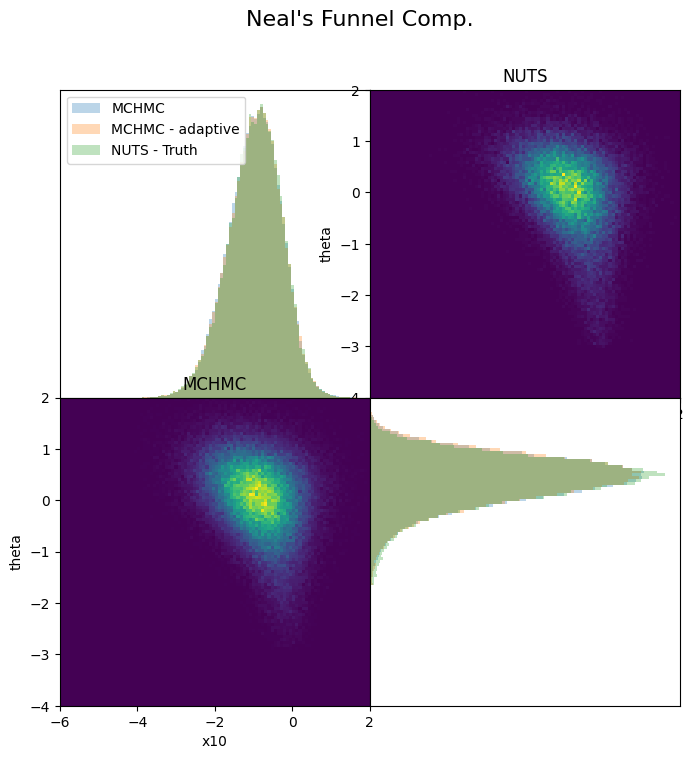

In [24]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="MCHMC")
axis[1,1].hist(x10_mchmc_adaptive, bins=100, density=true, range=[-6,2], alpha = 0.3, label="MCHMC - adaptive")
axis[1,1].hist(true_x10_hmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="NUTS - Truth")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(theta_mchmc_adaptive, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, density=true, orientation="horizontal", range=[-6,2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")
;